# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [24]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [0]:
??untar_data

    
### run the above cell.. and you can see that the code returns an object of type pathlib.Path
```
# This is formatted as code
Signature: untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
Source:   
def untar_data(url:str, fname:PathOrStr=None, dest:PathOrStr=None, data=True, force_download=False) -> Path:
    "Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`."
    dest = url2path(url, data) if dest is None else Path(dest)/url2name(url)
    fname = Path(ifnone(fname, _url2tgz(url, data)))
    if force_download or (fname.exists() and url in _checks and _check_file(fname) != _checks[url]):
        print(f"A new version of the {'dataset' if data else 'model'} is available.")
        os.remove(fname)
        shutil.rmtree(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, data=data)
        data_dir = Config().data_path()
        assert _check_file(fname) == _checks[url], f"Downloaded file {fname} does not match checksum expected! Remove that file from {data_dir} and try your code again."
        tarfile.open(fname, 'r:gz').extractall(dest.parent)
    return dest
```

In [26]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [27]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [29]:
type(path)

pathlib.PosixPath

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [30]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_154.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_157.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_41.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_129.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_199.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

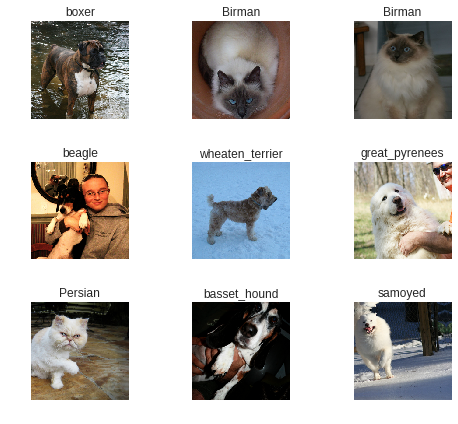

In [33]:
data.show_batch(rows=3, figsize=(7,6))

In [34]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [36]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [37]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.416507,0.306383,0.087957
2,0.573282,0.229635,0.070365
3,0.346508,0.200960,0.069012
4,0.262624,0.196824,0.063599


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

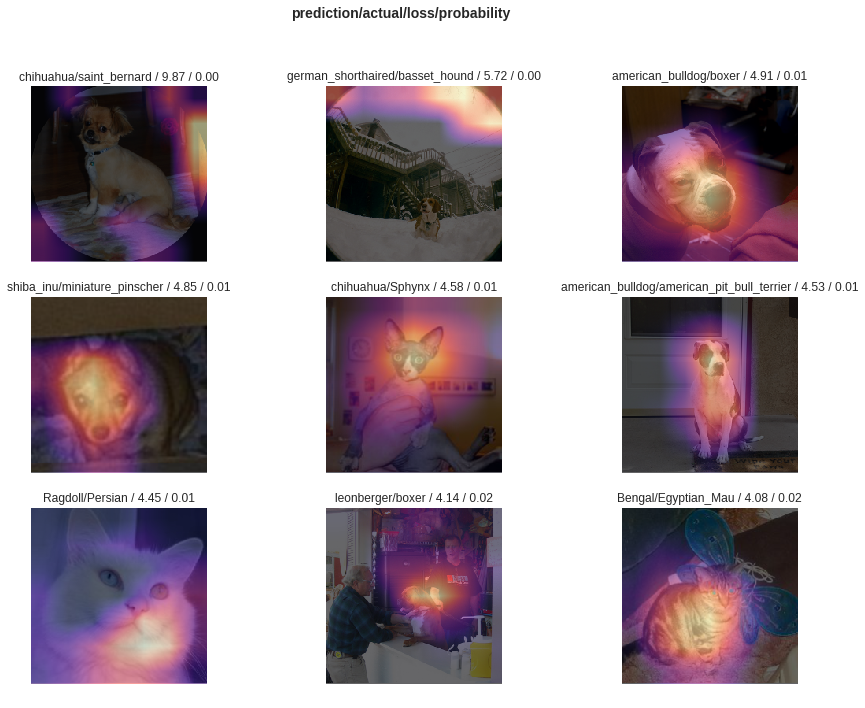

In [40]:
interp.plot_top_losses(9, figsize=(15,11)) # the images below are false color.. the heat map input var is set tot tru by default
#https://docs.fast.ai/vision.learner.html#plot_top_losses
#prediction, actual, loss, probability of actual class :: the valies on the top

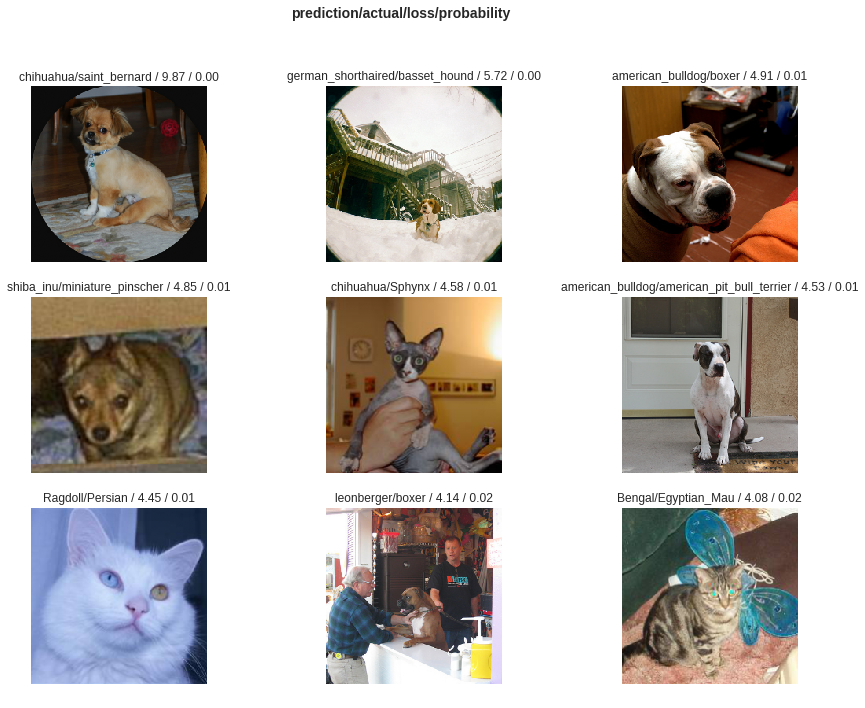

In [43]:
interp.plot_top_losses(9, figsize=(15,11), heatmap = False)

In [0]:
doc(interp.plot_top_losses)

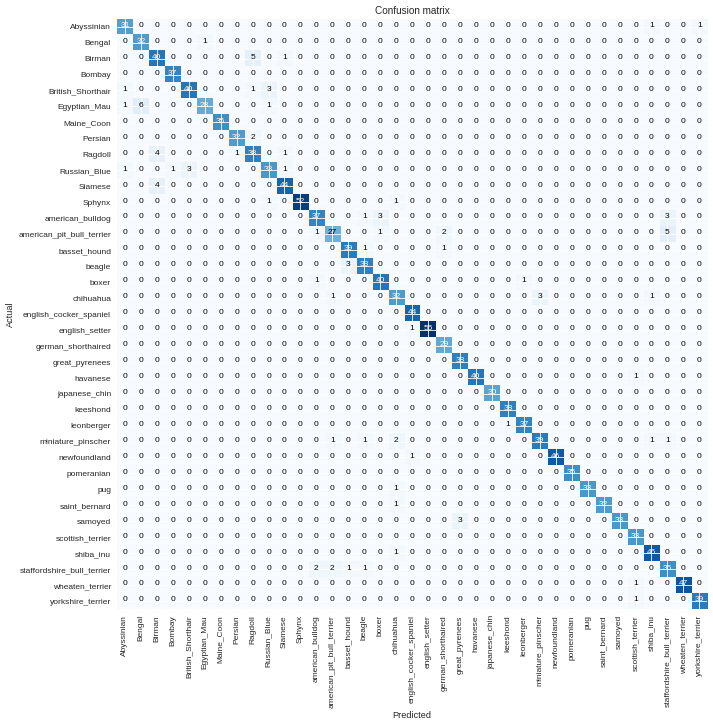

In [42]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('Birman', 'Ragdoll', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Ragdoll', 'Birman', 4),
 ('Siamese', 'Birman', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'boxer', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('beagle', 'basset_hound', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('samoyed', 'great_pyrenees', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()
# the previous fit _ one cycle() strips out the last layer.. and adds a layer thats representative of the target classificaiton
# the fit_one_cycle was training with the weights in the intermediate layers fixed.
# once we know that the model is getting in the right direction in terms of accuray...
# unfreeze.. the weights.. of the inter mediate layers.. 
# And train again...
# Once past this... there is no going back.. its a mile stone..


In [46]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.494074,0.302639,0.098782


In [0]:
# The error got much worse than the 6% we saw earlier

In [0]:
learn.load('stage-1'); # load the weights strained after the very first :: first fit_one_cycle(4)
# we are getting back to the model before we broke it as seen above... got a worse error rate didnt we..?

In [49]:
learn.lr_find() # this finds whats the fastest 1 can train this NN .. in a stable manner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


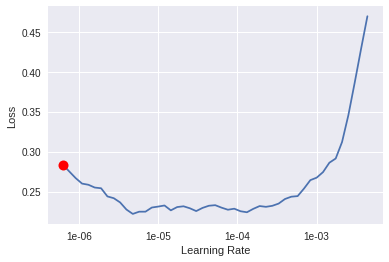

In [50]:
learn.recorder.plot() # the graph showss Loss vs LR

As once can observe from the graph.. the loss shoots up once the LR is greater than 10^(-4)

In [0]:
??learn.fit_one_cycle() # default is at 0.003.. which as seen in the plot above.. gives a lossy model



```
Signature: learn.fit_one_cycle(cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Tuple[float, float]=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, wd:float=None, callbacks:Union[Collection[fastai.callback.Callback], NoneType]=None, tot_epochs:int=None, start_epoch:int=1) -> None
Source:   
def fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[Floats,slice]=defaults.lr,
                  moms:Tuple[float,float]=(0.95,0.85), div_factor:float=25., pct_start:float=0.3,
                  wd:float=None, callbacks:Optional[CallbackList]=None, tot_epochs:int=None, start_epoch:int=1)->None:
    "Fit a model following the 1cycle policy."
    max_lr = learn.lr_range(max_lr)
    callbacks = listify(callbacks)
    callbacks.append(OneCycleScheduler(learn, max_lr, moms=moms, div_factor=div_factor, pct_start=pct_start, tot_epochs=tot_epochs, 
                                       start_epoch=start_epoch))
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)
File:      /usr/local/lib/python3.6/dist-packages/fastai/train.py
Type:      method
```



In [0]:
max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None)

In [55]:
max_lr #slice(start, stop, step)

slice(None, 0.003, None)

And the first part of the slice should be a value from your learning rate finder which is well before things started getting worse. So you can see things are starting to get worse maybe about here   
Source:: https://github.com/hiromis/notes/blob/master/Lesson1.md  


In [56]:
learn.unfreeze()# unfreeze the weights of all the layers..
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
# the slice here.. train first layer at LR : 1e-6 and the last layer at 1e-4, the rest of the layers in between
# at lr-s spread across the above range

epoch,train_loss,valid_loss,error_rate
1,0.234099,0.187303,0.061570
2,0.212032,0.184436,0.060217


That's a pretty accurate model!   
Rony: not really, error at first shot was 6.3 % now its 6.02.. marginal.. but yeath better

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)
#bs :: batch size was 64.. reducing it to 32.. so that .. you dont run out of mem low error..

This is a new model...  
Get a new instance of the pytorch data loader.. wrapped class aka databunch  
create a new learn/ create_cnn as seen below  

In [58]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:02, 44505912.68it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


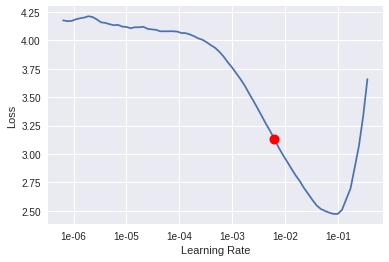

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.704389,0.268901,0.082544
2,0.375442,0.249287,0.079838
3,0.335434,0.223459,0.073748
4,0.256620,0.214424,0.066982
5,0.214517,0.194259,0.069012
6,0.150601,0.176572,0.056834
7,0.106684,0.162860,0.051421
8,0.119543,0.155863,0.050068


batch size is 32.. more wights takes 30+ mins

In [0]:
learn.save('stage-1-50') # save the weights of the resenet 50 model
# getds saved in the same folder/locaiton as the data bunch.. is created..

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [62]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.104757,0.166960,0.052774
2,0.093256,0.150620,0.052097
3,0.068723,0.151360,0.052774


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50'); # 5.2774 % error rate

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [65]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Ragdoll', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('beagle', 'basset_hound', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3)]

## Other data formats

In [66]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)# from_folder is used when the images.. are classified into foolders

In [69]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/train'),
 PosixPath('/root/.fastai/data/mnist_sample/valid')]

In [74]:
(path/'train').ls() as seen below 3 and 7 are the folder names ..

SyntaxError: ignored

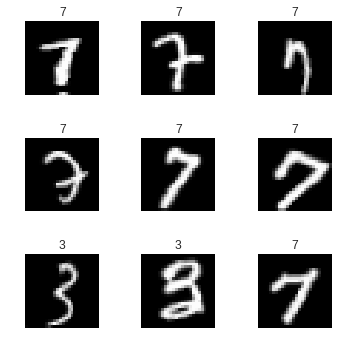

In [75]:
data.show_batch(rows=3, figsize=(5,5))

In [76]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 44205453.92it/s]


epoch,train_loss,valid_loss,accuracy
1,0.172416,0.086823,0.968106
2,0.114331,0.046814,0.985280


In [77]:
df = pd.read_csv(path/'labels.csv')
df.head() # this a case where the labels are stored in a csv.. or some such external file thats then loaded into a df

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

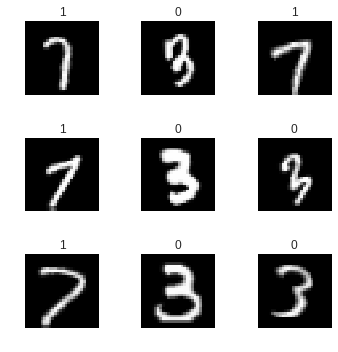

In [79]:
data.show_batch(rows=3, figsize=(5,5))
data.classes # 0 ==> 3 and 1 ==> 7

In [80]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [81]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [83]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes # ther egex captures the classes in the file name.. as seen in the paths above..

['3', '7']

In [85]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes # you can even pass a fucntion .. that captures classes..

['3', '7']

In [86]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [87]:
type(labels)

list

In [88]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']